In [1]:
import itertools

import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn import model_selection
from sklearn import preprocessing

import poker_coach

In [2]:
hero_range = range(0, 101, 10)
villain_range = range(0, 101, 10)
n_times = 10000

In [3]:
%%time

prod = itertools.product(hero_range, villain_range)

train = pd.DataFrame()

for h, v in prod:
    
    # Get hand from ranking.
    hero_hand = poker_coach.equity.percentage_descr(h)

    # Calculate equity agains villain range.
    equity = poker_coach.Scenario.eval_ranges(hero_hand, [v], times=n_times)
    
    train = train.append({"Hero": h, "Villain": v, "Equity": equity[0]}, ignore_index=True)
    
train.to_csv(r"poker_coach\data\linear_model_train.csv")
train.head()

KeyboardInterrupt: 

In [4]:
test_size = 0.25

test = pd.DataFrame()
for _ in range(int(train.shape[0] * test_size)):
    
    # Choose randomly hero and villain ranges.
    h = np.random.randint(min(hero_range), max(hero_range))
    hero_hand = poker_coach.equity.percentage_descr(h)
    v = np.random.randint(min(villain_range), max(villain_range))
    
    # Calculate equity agains villain range.
    equity = poker_coach.Scenario.eval_ranges(hero_hand, [v], times=n_times)
    
    test = test.append({"Hero": h, "Villain": v, "Equity": equity[0]}, ignore_index=True)
    
test.to_csv(r"poker_coach\data\linear_model_test.csv")
test.head()

,Equity,Hero,Villain
0,0.514477,16.0,26.0


In [5]:
x_train = train[["Hero", "Villain"]]
y_train = train[["Equity"]]

x_test = train[["Hero", "Villain"]]
y_test = train[["Equity"]]

reg = linear_model.LinearRegression()

poly = preprocessing.PolynomialFeatures(4)
x_train = poly.fit_transform(x_train)
x_test = poly.transform(x_test)

reg.fit(x_train, y_train)
reg.score(x_test, y_test)

1.0

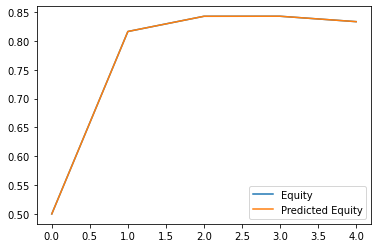

In [6]:
train["Predicted Equity"] = reg.predict(x_train)

sample = train[train["Hero"] == np.random.choice(train["Hero"])]
sample[["Equity", "Predicted Equity"]].plot()